# RNA Energy Barriers: Complexity Analysis

This notebook provides a formal analysis of the computational complexity of the algorithms implemented for finding RNA energy barriers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import RNA

from src.rna_structure import RNAStructure
from src.path_finding import find_direct_path, find_indirect_path
from src.energy import base_pair_minimization_energy, turner_energy
import src.evolution as ev

%load_ext autoreload
%autoreload 2

## 1. Theoretical Complexity Analysis

Let's analyze the theoretical time and space complexity of our algorithms for finding RNA energy barriers. We'll denote the length of the RNA sequence as `n`.

### 1.1 Direct Path Heuristic

The direct path heuristic has the following steps:
1. Determine which base pairs are in the start structure but not in the end structure (pairs to remove)
2. Determine which base pairs are in the end structure but not in the start structure (pairs to add)
3. Remove pairs that are in start but not in end, then add pairs that are in end but not in start

#### Time Complexity

When we analyze the algorithm without the turner energy evaluations:
1. Identify pairs to remove (in start but not in end): O(n)
2. Identify pairs to add (in end but not in start): O(n)
3. Generate the path by removing and adding pairs sequentially: O(n)
Since each RNA structure can have at most O(n) base pairs (where n is sequence length), the number of addition/removal operations is bounded by O(n).

Time Complexity: O(n)

#### Space Complexity

- We store the path, which contains at most 2m+1 structures
- Each structure requires O(n) space to store

Therefore, the space complexity is O(n²) in the worst case.

### 1.2 Indirect Path Heuristic

The indirect path heuristic uses a guided local search approach that allows exploration of structures not directly on the path from start to end:
- Tabu Search: Maintains a memory of recently visited structures to avoid cycles
- Beam Search: Considers multiple promising moves at each step, balancing energy and distance improvements
- Adaptive Randomness: Dynamically adjusts exploration vs. exploitation based on progress
- Direct Moves: Occasionally makes targeted moves directly toward the end structure when stuck

Unlike the direct path which only removes/adds base pairs from start/end structures, the indirect path can add "temporary" base pairs that exist in neither the start nor end structure, potentially finding lower-barrier pathways.

#### Time Complexity
Without turner energy evaluations:
1. Move Generation: For each position i (O(n)), we consider pairing with each position j ( (n)), and for each candidate pair, we check for conflicts with existing pairs (O(n)):  
Total move generation complexity: O(n³)
2. Move Selection: Calculating structural distances between configurations (O(n)) and sorting potential moves (O(n² log n))
3. Search Iterations: In worst case, we may need O(n) iterations to reach the target
4. Multiple Attempts: The algorithm makes indirect_attempts tries
  
Time Complexity: O(indirect_attempts × n⁴)

#### Space Complexity
- Path storage: O(n²) - storing up to O(n) structures, each requiring O(n) space
- Tabu list and visited structures: O(n²)
- Move candidates: O(n²)

Therefore, the overall space complexity is O(n²).

#### Practical Considerations
While the theoretical worst-case complexity is high, in practice the algorithm is much more efficient for several reasons:
- Pruning: The number of valid moves at each step is usually much smaller than O(n³) due to complementarity constraints and structural conflicts.
- Early termination: The algorithm often finds paths without exploring the entire theoretical search space.
- Guidance: The scoring function directs the search toward promising areas, avoiding exhaustive exploration.
- Multiple attempts: Running the algorithm multiple times with different randomization parameters increases the chances of finding good paths efficiently.

Compared to the direct path's O(n) time complexity, the indirect path is theoretically more expensive but can find lower energy barriers by exploring a larger portion of the folding landscape.




### 1.3 Evolutionary Approach

The evolutionary approach maintains a population of candidate structures and evolves them toward the target structure:

#### Time Complexity

Without turner energy evaluations:
1. Population Initialization: Creating N initial structures: O(N × n)
2. Per Generation Operations:
- Mutation: For each individual, generate and apply changes: O(N × n²)
- Crossover: Combining pairs of structures: O(N² × n)
- Selection: Evaluating fitness and selecting next generation: O(N log N)
3. Number of Generations


Time Complexity: O(max_steps × (N × n² + N² × n) × #generations)


Given that N is typically a constant, this simplifies to: O(max_steps × n² × #generations)

#### Space Complexity

- We store a population of N structures, each requiring O(n) space
- For each individual, we also store its path, which could grow to O(max_steps) length

Therefore, the space complexity is O(N × n × max_steps).

## 2. Why is the RNA Energy Barrier Problem NP-complete?

The RNA energy barrier problem is NP-complete because:

1. **Exponential Search Space**: The number of possible secondary structures for an RNA sequence grows exponentially with the sequence length.

2. **Local Minima**: The energy landscape contains many local minima, making it difficult to find the global minimum energy path.

3. **Barrier Height Verification**: Verifying that a given path has a barrier height less than some constant k can be done in polynomial time, making the problem NP.

4. **Reduction from Known NP-complete Problems**: The problem can be reduced from other NP-complete problems, such as the partition problem or the minimum feedback vertex set problem.

The barrier height computation has been shown to be NP-complete even under simple energy models, such as the base pair energy model where each base pair contributes -1 to the energy.

## 3. Empirical Complexity Analysis

Let's measure the actual running time of our algorithms on RNA sequences of varying lengths to empirically validate our complexity analysis.

In [2]:
def generate_random_rna(length):
    """Generate a random RNA sequence of given length"""
    bases = ['A', 'U', 'G', 'C']
    return ''.join(np.random.choice(bases) for _ in range(length))

In [3]:
def measure_direct_path_time(seq_length, num_trials=3):
    """Measure the time taken by the direct path algorithm for a given sequence length"""
    times = []
    
    for _ in range(num_trials):
        # Generate a random RNA sequence
        seq = generate_random_rna(seq_length)
        
        # Generate start and end structures
        fc = RNA.fold_compound(seq)
        start_struct, _ = fc.mfe()
        end_struct = '.' * seq_length  # Completely unpaired structure
        
        # Create RNA structure objects
        start = RNAStructure(seq, structure=start_struct)
        end = RNAStructure(seq, structure=end_struct)
        
        # Measure time for direct path finding
        start_time = time.time()
        path = find_direct_path(start, end)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return np.mean(times)

In [4]:
def measure_indirect_path_time(seq_length, num_trials=3):
    """Measure the time taken by the indirect path algorithm for a given sequence length"""
    times = []
    
    for _ in range(num_trials):
        # Generate a random RNA sequence
        seq = generate_random_rna(seq_length)
        
        # Generate start and end structures
        fc = RNA.fold_compound(seq)
        start_struct, _ = fc.mfe()
        end_struct = '.' * seq_length  # Completely unpaired structure
        
        # Create RNA structure objects
        start = RNAStructure(seq, structure=start_struct)
        end = RNAStructure(seq, structure=end_struct)
        
        # Measure time for direct path finding
        start_time = time.time()
        path = find_indirect_path(start, end)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return np.mean(times)

In [5]:
def measure_evolutionary_time(seq_length, num_trials=3, N=10, max_steps=100):
    """Measure the time taken by the evolutionary algorithm for a given sequence length"""
    times = []
    
    for _ in range(num_trials):
        # Generate a random RNA sequence
        seq = generate_random_rna(seq_length)
        
        # Generate start and end structures
        fc = RNA.fold_compound(seq)
        start_struct, _ = fc.mfe()
        end_struct = '.' * seq_length  # Completely unpaired structure
        
        # Measure time for evolutionary algorithm
        start_time = time.time()
        best, steps = ev.best_folding(seq, start_struct, end_struct, N=N, max_steps=max_steps)
        end_time = time.time()
        
        times.append(end_time - start_time)
    
    return np.mean(times)

In [6]:
# Measure running times for different sequence lengths
seq_lengths = [10, 30, 50, 70, 90, 100, 150, 200]
direct_times = []
indirect_times = []
evolutionary_times = []

for length in seq_lengths:
    print(f"Measuring for sequence length {length}...")
    direct_time = measure_direct_path_time(length)
    indirect_time = measure_indirect_path_time(length)
    evolutionary_time = measure_evolutionary_time(length)
    
    direct_times.append(direct_time)
    indirect_times.append(indirect_time)
    evolutionary_times.append(evolutionary_time)
    
    print(f"  Direct path time: {direct_time:.4f} seconds")
    print(f"  Indirect path time: {indirect_time:.4f} seconds")
    print(f"  Evolutionary time: {evolutionary_time:.4f} seconds")

Measuring for sequence length 10...
  Direct path time: 0.0000 seconds
  Indirect path time: 0.0000 seconds
  Evolutionary time: 0.0017 seconds
Measuring for sequence length 30...

Generation 10:
{'structure': '.((((......))))...............', 'distance': 8, 'highest_energy': 1.6999998092651367, 'path': ['(((((......)))))..............', '.((((......))))...............', '(((((......)))))..............', '.((((......))))...............', '(((((......)))))..............', '.((((......))))...............'], 'energy_profile': [0, -5.300000190734863, -7.0, -5.300000190734863, -7.0, -5.300000190734863]}

Generation 20:
{'structure': '..(((......)))................', 'distance': 6, 'highest_energy': 3.4000000953674316, 'path': ['(((((......)))))..............', '.((((......))))...............', '(((((......)))))..............', '.((((......))))...............', '(((((......)))))..............', '.((((......))))...............', '(((((......)))))..............', '.((((......))))..............

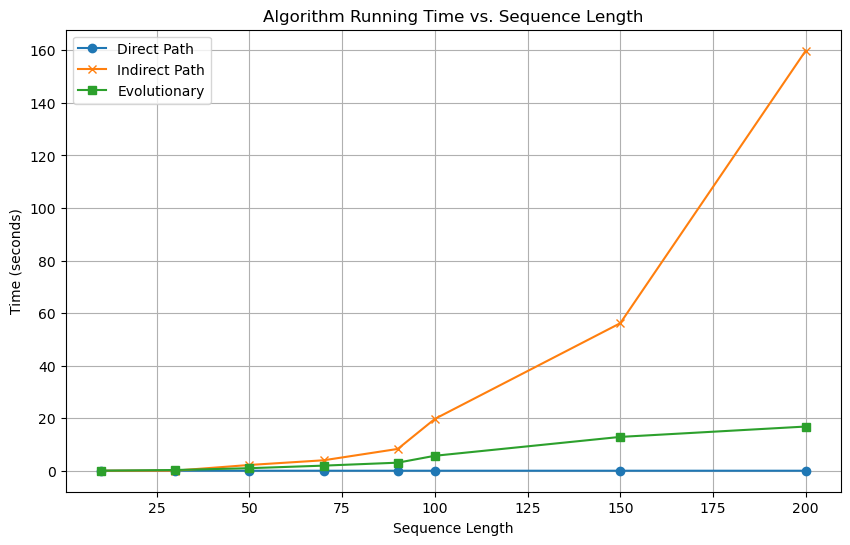

In [8]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(seq_lengths, direct_times, 'o-', label='Direct Path')
plt.plot(seq_lengths, indirect_times, 'x-', label='Indirect Path')
plt.plot(seq_lengths, evolutionary_times, 's-', label='Evolutionary')
plt.xlabel('Sequence Length')
plt.ylabel('Time (seconds)')
plt.title('Algorithm Running Time vs. Sequence Length')
plt.legend()
plt.grid(True)
plt.show()

## 4. How Our Heuristics Approximate Solutions

Given that the RNA energy barrier problem is NP-complete, our heuristics provide practical approximations to the optimal solution. Here's how they work:

### 4.1 Direct Path Heuristic

The direct path heuristic makes a significant simplification by only considering paths that directly transform the start structure into the end structure, without any "detours." This drastically reduces the search space from exponential to polynomial size.

**Approximation Quality**:
- In cases where the optimal path is indeed direct, this heuristic finds the exact solution.
- However, when the optimal path requires intermediate structures that are not steps toward the end structure, the direct path can yield much higher energy barriers.
- The quality of approximation depends on the "smoothness" of the energy landscape between the start and end structures.

### 4.2 Indirect Path Heuristic

The indirect path heuristic employs a guided local search that allows exploration of intermediate structures that may not be steps directly toward the end structure. It uses tabu search, beam selection, and adaptive randomness to navigate the folding landscape efficiently.

**Approximation Quality:**
- Unlike the direct path, it can discover lower energy pathways by allowing "temporary" base pairs that exist in neither the start nor end structure.
- The tabu mechanism and adaptive randomness help escape local minima that would trap a direct path search.
- Multiple attempts with different randomization parameters increase the likelihood of finding near-optimal solutions.
- The quality of approximation depends on the tabu list size, beam width, and randomness parameters.
- While more computationally intensive than the direct path, it typically finds significantly better barriers for complex RNA structures.

### 4.3 Evolutionary Approach

The evolutionary approach uses a population-based search that allows for exploration of a broader range of paths, including non-direct ones.

**Approximation Quality**:
- By maintaining a diverse population of candidate solutions, it can potentially escape local minima.
- The selection pressure guides the search toward lower energy barriers.
- The quality of approximation depends on population size, number of generations, and selection parameters.
- While still not guaranteed to find the global optimum, it typically finds better solutions than the direct path heuristic, especially in complex energy landscapes.

## 5. Summary of Complexity Analysis

- **Direct Path:** O(n) - Fastest but most restrictive
- **Indirect Path:** O(indirect_attempts × n⁴) - More thorough search with higher complexity
- **Evolutionary:** O(max_steps × n² × #generations) - Scales well with sequence length but depends on the maximum number of iterations

The direct path heuristic provides a polynomial-time approximation but may miss optimal solutions that require non-direct paths.

The indirect path heuristic offers a good balance between efficiency and solution quality, using strategic exploration to find lower energy barriers while maintaining polynomial complexity through guided search techniques.

In practice, the choice of algorithm depends on the tradeoff between solution quality and computational resources available.